Aggregating data to the level of individuals

In [38]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
from bsmcalls import individuals
from bsmcalls import readVCF
from bsmcalls import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
import fwsel
import re
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import calls and clinical data and filter for NeuN+ samples

In [2]:
calls, clin = individuals.get_data(merge=False)
calls = calls.loc(axis=0)[:, 'NeuN_pl']

In [3]:
aggcalls = individuals.agg_calls(calls)
data = pd.concat([aggcalls, clin], axis=1)

In [4]:
aggcalls

Variable      nCalls        AF           BaseQRankSum                    DP  \
Transform      count      mean       std         mean       std        mean   
Individual ID                                                                 
CMC_MSSM_027      56  0.094286  0.110055     1.394286  2.469961  202.892857   
CMC_MSSM_055      49  0.046939  0.068380     2.242102  2.001271  255.020408   
CMC_MSSM_056       9  0.082222  0.040552     1.131333  2.036603  104.222222   
CMC_MSSM_069      12  0.106667  0.032287    -0.287417  2.675964   58.916667   
CMC_MSSM_097      96  0.078125  0.131135     1.063500  2.669541  372.781250   
...              ...       ...       ...          ...       ...         ...   
CMC_PITT_098      26  0.102308  0.059686     0.961385  1.958133  161.230769   
CMC_PITT_101      13  0.123077  0.092681     1.000154  1.917042  130.769231   
CMC_PITT_113      33  0.103030  0.159462     0.546909  3.012843  251.727273   
CMC_PITT_117      17  0.096471  0.086958     1.080529  1.835480  182.411765   
CMC_PITT_118      42  0.066190  0.054188     0.841714  2.103925  221.452381   

Variable                         FS                  SOR  ...       ALT  \
Transform            std       mean        std      mean  ...   entropy   
Individual ID                                             ...             
CMC_MSSM_027   27.324766   2.737946   3.867827  0.981536  ...  1.179373   
CMC_MSSM_055   25.005408   2.351408   2.822638  1.120061  ...  1.055851   
CMC_MSSM_056   10.802520   1.398000   1.819863  0.813111  ...  1.149060   
CMC_MSSM_069    6.141636  12.272083  11.296428  2.714083  ...  1.236685   
CMC_MSSM_097   58.511034   1.965771   2.715713  0.887000  ...  1.205730   
...                  ...        ...        ...       ...  ...       ...   
CMC_PITT_098   14.475656   2.299462   2.279725  0.935885  ...  1.263735   
CMC_PITT_101   12.410707   1.480077   1.671059  0.823077  ...  1.351681   
CMC_PITT_113   22.765479   1.648909   1.838384  0.977273  ...  1.169702   
CMC_PITT_117   19.419896   3.010176   2.533470  1.063294  ...  1.071018   
CMC_PITT_118   16.920477   2.593690   2.894319  1.057952  ...  1.168650   

Variable        FILTER/PASS                       culprit                      \
Transform         marg_mode frequency   entropy marg_mode frequency   entropy   
Individual ID                                                                   
CMC_MSSM_027   HC;PASS/PASS  0.750000  0.872250        QD  0.946429  0.242999   
CMC_MSSM_055   HC;PASS/PASS  0.673469  0.902886        QD  0.979592  0.099623   
CMC_MSSM_056   HC;PASS/PASS  0.666667  0.848686        QD  0.888889  0.348832   
CMC_MSSM_069   HC;PASS/PASS  0.250000  1.314374        QD  1.000000  0.000000   
CMC_MSSM_097   HC;PASS/PASS  0.416667  1.254138        QD  0.875000  0.487732   
...                     ...       ...       ...       ...       ...       ...   
CMC_PITT_098   HC;PASS/PASS  0.923077  0.271189        QD  1.000000  0.000000   
CMC_PITT_101   HC;PASS/PASS  0.769231  0.687092        QD  0.769231  0.687092   
CMC_PITT_113   HC;PASS/PASS  0.636364  1.047320        QD  0.969697  0.135794   
CMC_PITT_117   HC;PASS/PASS  0.882353  0.362211        QD  0.941176  0.223718   
CMC_PITT_118   HC;PASS/PASS  0.857143  0.474482        QD  0.976190  0.112516   

Variable      ChromatinState_DLPFC                      
Transform                marg_mode frequency   entropy  
Individual ID                                           
CMC_MSSM_027                 Quies  0.732143  0.965981  
CMC_MSSM_055                 Quies  0.632653  1.152910  
CMC_MSSM_056                 Quies  0.666667  0.848686  
CMC_MSSM_069                 Quies  0.750000  0.836988  
CMC_MSSM_097                 Quies  0.687500  1.030783  
...                            ...       ...       ...  
CMC_PITT_098                 Quies  0.615385  1.318487  
CMC_PITT_101                 Quies  0.769231  0.540204  
CMC_PITT_113                 Quies  0.666667  1.110038  
CMC_PITT_117           

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, CMC_MSSM_027 to CMC_PITT_118
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   (nCalls, count)                    86 non-null     int64   
 1   (AF, mean)                         86 non-null     float64 
 2   (AF, std)                          86 non-null     float64 
 3   (BaseQRankSum, mean)               86 non-null     float64 
 4   (BaseQRankSum, std)                86 non-null     float64 
 5   (DP, mean)                         86 non-null     float64 
 6   (DP, std)                          86 non-null     float64 
 7   (FS, mean)                         86 non-null     float64 
 8   (FS, std)                          86 non-null     float64 
 9   (SOR, mean)                        86 non-null     float64 
 10  (SOR, std)                         86 non-null     float64 
 11  (VQSLOD, mean)                 

### Correlations

['named-figure/corrmat-indiv-based.png',
 'named-figure/corrmat-indiv-based.pdf']

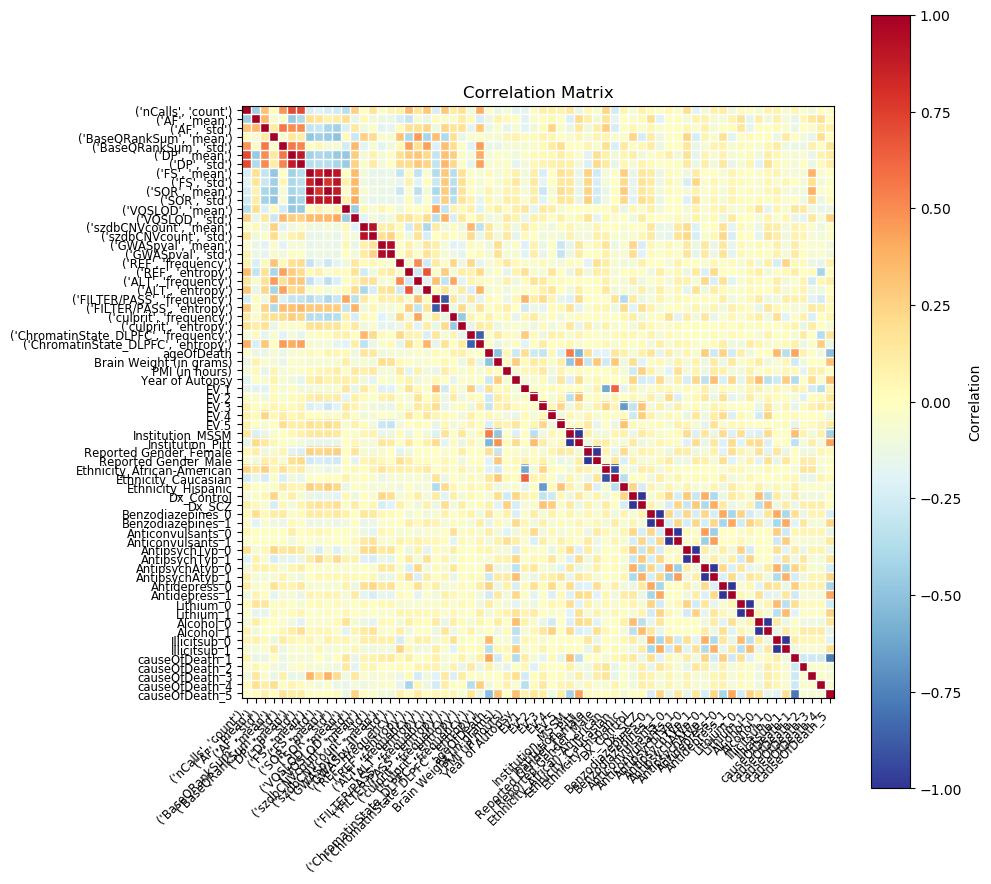

In [41]:
datanum = preprocessing.dummify_df(data)
def corrmatplot(dfnum):
    corrmat = dfnum.corr()
    fig, ax = plt.subplots(figsize=(10,10))
    sm.graphics.plot_corr(corrmat, ax=ax, xnames=corrmat.columns, ynames=corrmat.columns)
    cb = plt.colorbar(ax.get_images()[0])
    cb.set_label('Correlation')
    return((fig, ax))
fig, ax = corrmatplot(datanum)
attila_utils.savefig(fig, 'corrmat-indiv-based')

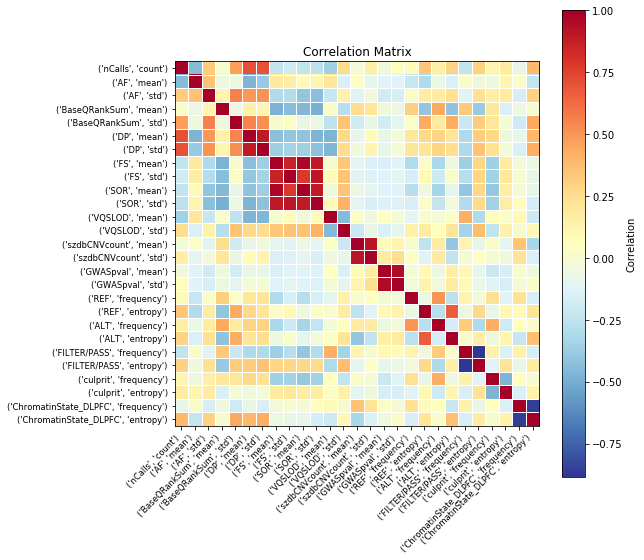

In [7]:
fig, ax = corrmatplot(datanum.loc[:, :('ChromatinState_DLPFC', 'entropy')])
fig.set_size_inches(8, 8)

In [8]:
collinear_cols = ['DP_std', 'FS_std', 'SOR_mean', 'SOR_std', 'szdbCNVcount_std', 'GWASpval_std']

## Modeling: Dx as response

First let's preprocess the data

In [9]:
def preprocess_filter(data, c2d=collinear_cols):
    data1 = preprocessing.preprocess(data)
    # we remove the marginal modes since these are all degenerate variables
    cols2drop = [y for y in data1.columns if re.match('.*_marg_mode', y)]
    data1 = data1.drop(columns=cols2drop + c2d)
    return(data1)

data1 = preprocess_filter(data, c2d=[]) # we omit the removing of collinear_cols

### Forward variable selection

In [10]:
best1 = fwsel.forward_selected(data1, 'Dx')

In [11]:
best1.model.formula

'Dx ~ AntipsychAtyp + YearofAutopsy + AntipsychTyp + EV3 + Institution + Benzodiazepines + causeOfDeath + Ethnicity + FILTERPASS_entropy + REF_entropy + BrainWeightingrams + EV4 + BaseQRankSum_mean + Antidepress + REF_frequency + ChromatinState_DLPFC_frequency + FILTERPASS_frequency + ALT_frequency + DP_std + SOR_std + VQSLOD_std + ReportedGender + VQSLOD_mean + 1'

In [12]:
best1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Dx   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     9.386
Date:                Wed, 14 Oct 2020   Prob (F-statistic):           8.15e-13
Time:                        12:34:10   Log-Likelihood:                 18.138
No. Observations:                  86   AIC:                             19.72
Df Residuals:                      58   BIC:                             88.45
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.5403      0.100      5.377      0.000       0.339       0.741
AntipsychAtyp[T.1]                 0.5409      0.069      7.873      0.000       0.403       0.678
AntipsychTyp[T.1]                  0.3604      0.087      4.132      0.000       0.186       0.535
Institution[T.Pitt]                0.0159      0.093      0.172      0.864      -0.169       0.201
Benzodiazepines[T.1]              -0.1280      0.095     -1.354      0.181      -0.317       0.061
causeOfDeath[T.2]                  0.3308      0.196      1.686      0.097      -0.062       0.724
causeOfDeath[T.3]                  0.3673      0.212      1.732      0.089      -0.057       0.792
causeOfDeath[T.4]                 -0.1046      0.238     -0.440      0.662      -0.580       0.371
causeOfDeath[T.5]                  0.1290      0.100      1.294      0.201      -0.071       0.329
Ethnicity[T.Caucasian]             0.0435      0.090      0.482      0.632      -0.137       0.224
Ethnicity[T.Hispanic]             -0.4895      0.309     -1.583      0.119      -1.108       0.129
Antidepress[T.1]                  -0.1925      0.092     -2.097      0.040      -0.376      -0.009
ReportedGender[T.Male]            -0.1063      0.070     -1.525      0.133      -0.246       0.033
YearofAutopsy                     -0.1656      0.034     -4.827      0.000      -0.234      -0.097
EV3                                0.0930      0.039      2.364      0.021       0.014       0.172
FILTERPASS_entropy                 0.2036      0.076      2.672      0.010       0.051       0.356
REF_entropy                       -0.1861      0.042     -4.455      0.000      -0.270      -0.102
BrainWeightingrams                -0.1054      0.038     -2.747      0.008      -0.182      -0.029
EV4                                0.0556      0.030      1.866      0.067      -0.004       0.115
BaseQRankSum_mean                 -0.1065      0.043     -2.468      0.017      -0.193      -0.020
REF_frequency                      0.0968      0.037      2.588      0.012       0.022       0.172
ChromatinState_DLPFC_frequency    -0.0327      0.032     -1.029      0.308      -0.096       0.031
FILTERPASS_frequency               0.1901      0.085      2.237      0.029       0.020       0.360
ALT_frequency                     -0.0844      0.044     -1.940      0.057      -0.172       0.003
DP_std                             0.1272      0.051      2.480      0.016       0.025       0.230
SOR_std                            0.1189      0.051      2.347      0.022       0.017       0.220
VQSLOD_std                        -0.0980      0.041     -2.366      0.021      -0.181      -0.015
VQSLOD_mean                       -0.0456      0.039     -1.173      0.246      -0.123       0.032
==============

## Simple univariate regression

Fitting logit
Optimization terminated successfully.
         Current function value: 0.558083
         Iterations 7
Fitting probit
Optimization terminated successfully.
         Current function value: 0.557065
         Iterations 6


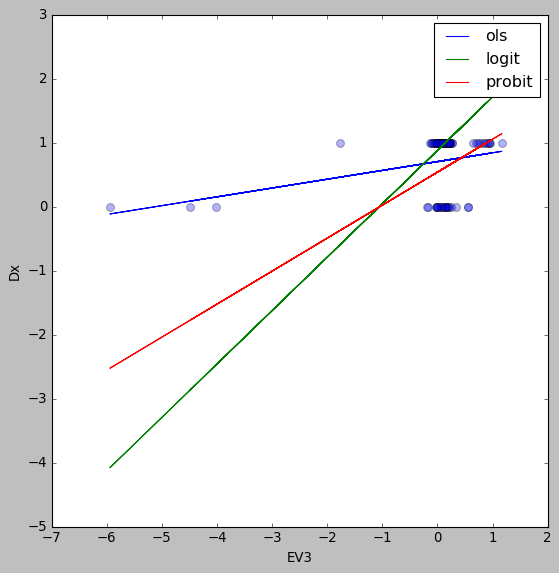

In [13]:
%matplotlib inline
plt.style.use('classic')

def simple_reg(sel_col='EV3', data=data1):
    f = 'Dx ~ ' + sel_col
    lin = smf.ols(formula=f, data=data1).fit()
    print('Fitting logit')
    logi = smf.logit(formula=f, data=data1).fit()
    print('Fitting probit')
    probi = smf.probit(formula=f, data=data1).fit()
    #p = sm.graphics.plot_regress_exog(lin, sel_col)
    fig, ax = plt.subplots(figsize=(8, 8))
    data.plot(x=sel_col, y='Dx', kind='scatter', alpha=0.3, s=50, marker='o', ax=ax)
    ax.plot(data[sel_col].values, lin.fittedvalues.values, label='ols')
    ax.plot(data[sel_col].values, logi.fittedvalues.values, label='logit')
    ax.plot(data[sel_col].values, probi.fittedvalues.values, label='probit')
    ax.legend()
    return((lin, logi, probi))

mm = simple_reg('EV3')

Fitting logit
Optimization terminated successfully.
         Current function value: 0.599428
         Iterations 5
Fitting probit
Optimization terminated successfully.
         Current function value: 0.599299
         Iterations 5


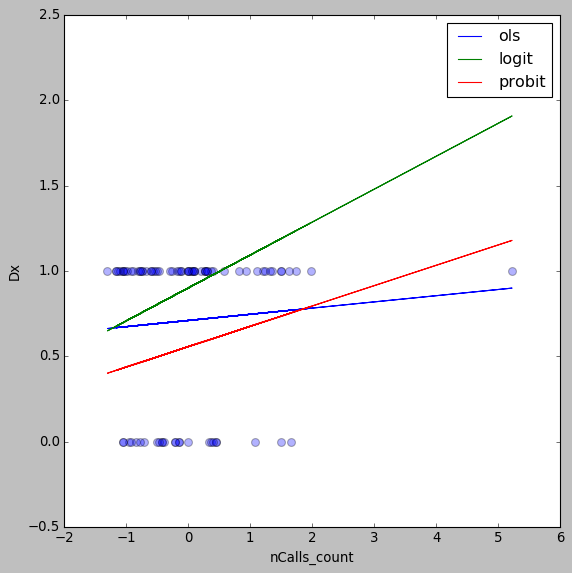

In [14]:
mm = simple_reg('nCalls_count', data=data1)

## Modeling: nCalls as response

The idea is to use the nCalls variable as response.  Benefits include:
* nCalls is better suited for linear modeling since it can be considered as a continuous response variable
* technical variables that affect nCalls such as read depth (see below) can be incorporated into the model

### Visual exploration

Text(0.5, 0.98, 'no. calls and read depth')

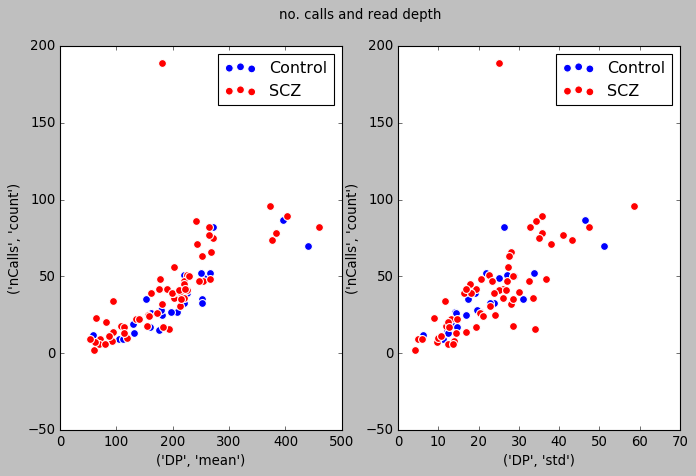

In [15]:
def myscatter(ax, x=('DP', 'mean'), y=('nCalls', 'count')):
    df = data.loc[data['Dx'] == 'Control', [x, y]]
    ax.scatter(x=df[x], y=df[y], label='Control', c='b', edgecolors='white', s=50)
    df = data.loc[data['Dx'] == 'SCZ', [x, y]]
    ax.scatter(x=df[x], y=df[y], label='SCZ', c='r', edgecolors='white', s=50)
    ax.set_ylabel(y)
    ax.set_xlabel(x)
    ax.legend()
    return(ax)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
myscatter(ax=ax[0], x=('DP', 'mean'), y=('nCalls', 'count'))
myscatter(ax=ax[1], x=('DP', 'std'), y=('nCalls', 'count'))
fig.suptitle('no. calls and read depth')

['named-figure/numcalls-depth-Dx.png', 'named-figure/numcalls-depth-Dx.pdf']

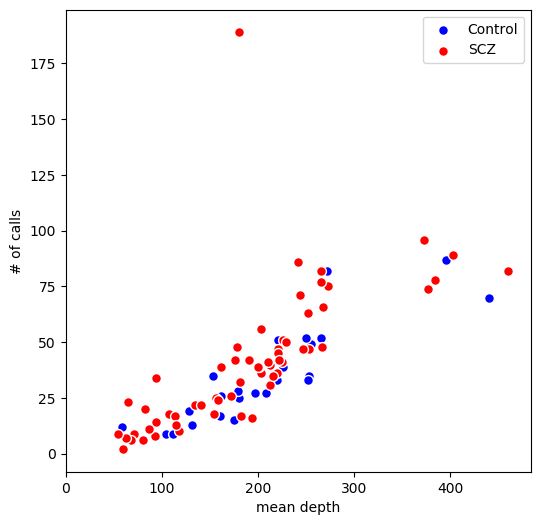

In [16]:
plt.style.use('default')
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = myscatter(ax=ax, x=('DP', 'mean'), y=('nCalls', 'count'))
ax.set_xlabel('mean depth')
ax.set_ylabel('# of calls')
ax.set_xlim(0)
attila_utils.savefig(fig, 'numcalls-depth-Dx')

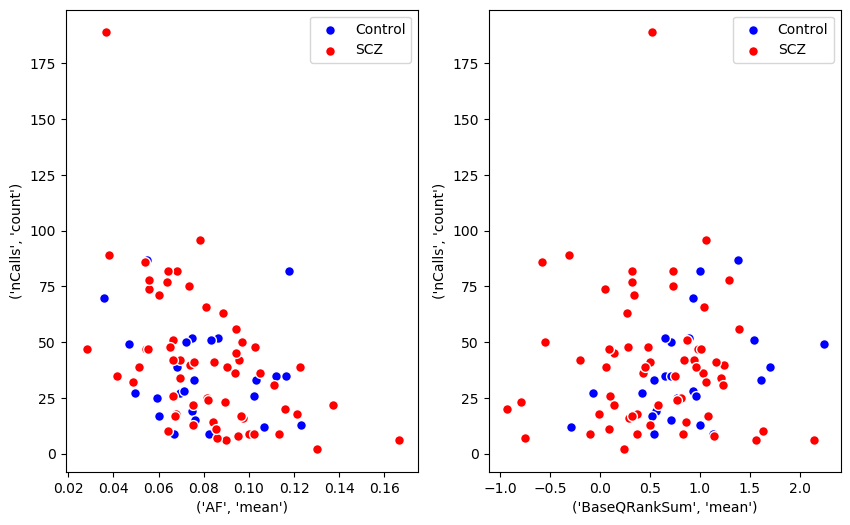

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
myscatter(ax=ax[0], x=('AF', 'mean'), y=('nCalls', 'count'))
myscatter(ax=ax[1], x=('BaseQRankSum', 'mean'), y=('nCalls', 'count'))

### Finding the outlier

In [18]:
data[('nCalls', 'count')].sort_values()

CMC_MSSM_201      2
CMC_MSSM_266      6
CMC_MSSM_331      6
CMC_MSSM_293      7
CMC_MSSM_308      8
               ... 
CMC_MSSM_343     86
CMC_MSSM_406     87
CMC_MSSM_213     89
CMC_MSSM_097     96
CMC_MSSM_224    189
Name: (nCalls, count), Length: 86, dtype: int64

In [19]:
clin.loc['CMC_MSSM_224']

Institution                            MSSM
Reported Gender                      Female
Ethnicity                  African-American
ageOfDeath                               53
Brain Weight (in grams)                1130
PMI (in hours)                          6.3
Dx                                      SCZ
Year of Autopsy                        2001
Benzodiazepines                           0
Anticonvulsants                           0
AntipsychTyp                              0
AntipsychAtyp                             1
Antidepress                               0
Lithium                                   0
Alcohol                                   0
Illicitsub                                0
causeOfDeath                              1
EV.1                              -0.080551
EV.2                               0.000982
EV.3                               0.035962
EV.4                               0.000456
EV.5                               0.006669
Name: CMC_MSSM_224, dtype: objec

### Forward variables selection

In [20]:
best1 = fwsel.forward_selected(data1, 'nCalls_count')

In [21]:
best1.model.formula

'nCalls_count ~ DP_mean + culprit_entropy + ReportedGender + DP_std + AF_mean + Ethnicity + AntipsychAtyp + YearofAutopsy + Anticonvulsants + REF_entropy + szdbCNVcount_std + EV1 + Lithium + Alcohol + EV3 + 1'

In [22]:
best1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           nCalls_count   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     11.63
Date:                Wed, 14 Oct 2020   Prob (F-statistic):           7.48e-14
Time:                        12:34:26   Log-Likelihood:                -65.299
No. Observations:                  86   AIC:                             164.6
Df Residuals:                      69   BIC:                             206.3
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.3692      0.231      1.602      0.114      -0.091       0.829
ReportedGender[T.Male]    -0.3652      0.148     -2.473      0.016      -0.660      -0.071
Ethnicity[T.Caucasian]    -0.1675      0.246     -0.682      0.498      -0.658       0.323
Ethnicity[T.Hispanic]     -0.0848      0.655     -0.130      0.897      -1.391       1.222
AntipsychAtyp[T.1]         0.3714      0.170      2.180      0.033       0.031       0.711
Anticonvulsants[T.1]      -0.4840      0.235     -2.061      0.043      -0.952      -0.016
Lithium[T.1]              -0.6668      0.618     -1.080      0.284      -1.899       0.565
Alcohol[T.1]              -0.2000      0.173     -1.154      0.252      -0.546       0.146
DP_mean                    0.2075      0.154      1.345      0.183      -0.100       0.515
culprit_entropy            0.1692      0.064      2.625      0.011       0.041       0.298
DP_std                     0.4239      0.154      2.760      0.007       0.117       0.730
AF_mean                   -0.2033      0.078     -2.609      0.011      -0.359      -0.048
YearofAutopsy             -0.1352      0.073     -1.845      0.069      -0.281       0.011
REF_entropy                0.1507      0.077      1.963      0.054      -0.002       0.304
szdbCNVcount_std           0.1325      0.071      1.874      0.065      -0.009       0.274
EV1                       -0.1243      0.085     -1.467      0.147      -0.293       0.045
EV3                        0.0990      0.093      1.061      0.292      -0.087       0.285
==============================================================================
Omnibus:                       68.775   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              632.962
Skew:                           2.279   Prob(JB):                    3.58e-138
Kurtosis:                      15.485   Cond. No.                         17.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Remove redundant (collinear) columns

In [23]:
data2 = preprocess_filter(data, c2d=collinear_cols) # we remove collinear_cols
best2 = fwsel.forward_selected(data2, 'nCalls_count')

In [24]:
best2.model.formula

'nCalls_count ~ DP_mean + culprit_entropy + ReportedGender + AF_mean + Ethnicity + YearofAutopsy + AntipsychAtyp + BaseQRankSum_std + EV1 + szdbCNVcount_mean + REF_entropy + Anticonvulsants + 1'

Selected variables in `best1.model` that persisted in `best2.model`:

In [25]:
set(best2.model.exog_names).intersection(set(best1.model.exog_names))

{'AF_mean',
 'Anticonvulsants[T.1]',
 'AntipsychAtyp[T.1]',
 'DP_mean',
 'EV1',
 'Ethnicity[T.Caucasian]',
 'Ethnicity[T.Hispanic]',
 'Intercept',
 'REF_entropy',
 'ReportedGender[T.Male]',
 'YearofAutopsy',
 'culprit_entropy'}

Selected variables in `best2.model` that weren't selected in `best1.model`:

In [26]:
set(best2.model.exog_names) - set(best1.model.exog_names)

{'BaseQRankSum_std', 'szdbCNVcount_mean'}

Previously selected variables that dropped out in `best2.model`:

In [27]:
set(best1.model.exog_names) - set(best2.model.exog_names)

{'Alcohol[T.1]', 'DP_std', 'EV3', 'Lithium[T.1]', 'szdbCNVcount_std'}

## Transcription start sites hypothesis

The above analysis did not suggest involvement of chromatin state in somatic risk variants for schizophrenia.  However, our previous descriptive statistical analysis (2020-06-10-annotate-explore-variants)showed tendency for the enrichment of transcription start sites (TssA and TssAFlnk) in SCZ somatic variants relative to Control.  Why is this discrepancy?

The discrepancy might have arisen because the `ChromatinState_DLPFC` factor has 15 levels thus increases the degrees of freedom by quite a lot (14 to be precise) in regression models.  Here I test this hypothesis by merging the 15 levels into only two levels: one containing TssA and TssAFlnk while the other all the other 13 chromatin states.

In [28]:
calls_tss = calls.copy()
s = calls['ChromatinState_DLPFC']
d = {'TssA': ['TssA', 'TssAFlnk'],  'Other': ['TxFlnk', 'Tx', 'TxWk', 'EnhG', 'Enh', 'ZNF/Rpts', 'Het', 'TssBiv', 'ReprPC', 'ReprPCWk', 'Quies']} 
calls_tss['ChromatinState_DLPFC'] = preprocessing.collapse_categories(s, d)

In [29]:
aggcalls_tss = individuals.agg_calls(calls_tss)
data_tss = pd.concat([aggcalls_tss, clin], axis=1)
data2_tss = preprocess_filter(data_tss, c2d=collinear_cols) # we remove collinear_cols

In [30]:
best2_tss = fwsel.forward_selected(data2_tss, 'nCalls_count')

In [31]:
best2_tss.model.formula

'nCalls_count ~ DP_mean + culprit_entropy + ReportedGender + AF_mean + Ethnicity + ChromatinState_DLPFC_entropy + ChromatinState_DLPFC_frequency + EV1 + YearofAutopsy + AntipsychAtyp + Institution + Anticonvulsants + BrainWeightingrams + AF_std + Illicitsub + ageOfDeath + szdbCNVcount_mean + 1'

Selected variables in `best2.model` that persisted in `best2_tss.model`:

In [32]:
set(best2_tss.model.exog_names).intersection(set(best2.model.exog_names))

{'AF_mean',
 'Anticonvulsants[T.1]',
 'AntipsychAtyp[T.1]',
 'DP_mean',
 'EV1',
 'Ethnicity[T.Caucasian]',
 'Ethnicity[T.Hispanic]',
 'Intercept',
 'ReportedGender[T.Male]',
 'YearofAutopsy',
 'culprit_entropy',
 'szdbCNVcount_mean'}

Selected variables in `best2_tss.model` that weren't selected in `best2.model`:

In [33]:
set(best2_tss.model.exog_names) - set(best2.model.exog_names)

{'AF_std',
 'BrainWeightingrams',
 'ChromatinState_DLPFC_entropy',
 'ChromatinState_DLPFC_frequency',
 'Illicitsub[T.1]',
 'Institution[T.Pitt]',
 'ageOfDeath'}

Previously selected variables in `best2.model` that dropped out in `best2_tss.model`:

In [34]:
set(best2.model.exog_names) - set(best2_tss.model.exog_names)

{'BaseQRankSum_std', 'REF_entropy'}

In [35]:
%connect_info

{
  "shell_port": 51541,
  "iopub_port": 37079,
  "stdin_port": 37615,
  "control_port": 56905,
  "hb_port": 52923,
  "ip": "127.0.0.1",
  "key": "f8013caa-69e6f72aaf1998fa320fe83a",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-78afeb9e-7740-473d-ab83-e87284c03e33.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
